REFERENCEs:
Wilks "Statistical Methods in the Atmospheric Sciences" 4th edition 2019
pg 115-118

lmoments library python  https://lmoments3.readthedocs.io/_/downloads/en/stable/pdf/

https://stackoverflow.com/questions/52455797/python-fitting-a-gev-distribution-from-these-values

In [8]:
import joblib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import genextreme as gev
import lmoments3 as lm3
import lmoments3.distr as ldist 

In [9]:
rainfall_data = joblib.load('rainfall_data_2011_2020_835x_520y.pkl') #10min rain
rain_resampled = rainfall_data.resample(time='1H').sum()

print(f"Maximum rainfall in your resample data is: {rain_resampled.values.max()} mm")

# Get the annual maxima

annual_max = rain_resampled.resample(time='1Y').max()
annual_max = annual_max.dropna('time')
POT_threshold = min(annual_max.values) # Peak Over Threshold

print(f"Threshold for POT is: {POT_threshold} mm")

Maximum rainfall in your resample data is: 53.32096862792969 mm
Threshold for POT is: 20.40349769592285 mm


In [10]:
rain_POT = rain_resampled.where(rain_resampled >= POT_threshold, drop=True)  # Peak Over Threshold
print(f"Number of POT events: {rain_POT.count()}")

Number of POT events: <xarray.DataArray 'RAIN' ()>
array(59)


### D. Fit distribution to GEV using Maximum Likelihood Estimation

In [11]:
shape, loc, scale = gev.fit(rain_POT)
l = loc + scale / shape
print('Fitting to GEV distribution using MLE')
print(f"Shape: {shape}, Location: {loc}, Scale: {scale}")

Fitting to GEV distribution using MLE
Shape: -0.6868051426364445, Location: 23.069584353613994, Scale: 3.2186173374749565


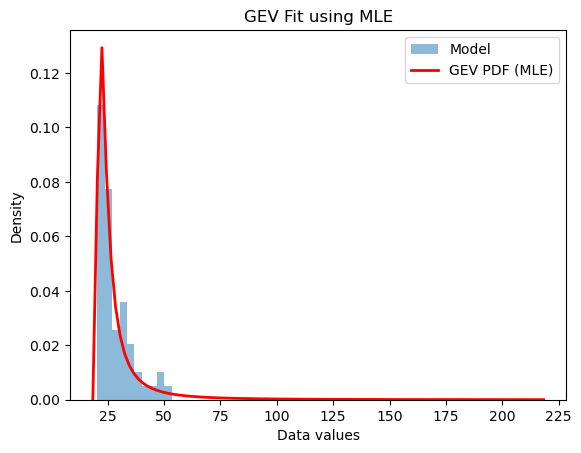

In [12]:
#Plotting
xx = np.linspace(l+0.00001, l+0.00001+200, num=100)
#xx = np.linspace(min(rain_over_threshold), max(rain_over_threshold), 100)
pdf_gev = gev.pdf(xx, shape, loc, scale)
plt.hist(rain_POT, bins=10, density=True, alpha=0.5, label="Model")
plt.plot(xx, pdf_gev, 'r-', lw=2, label="GEV PDF (MLE)")
plt.xlabel("Data values")
plt.ylabel("Density")
plt.title("GEV Fit using MLE")
plt.legend()
plt.show()


### E. Fit distribution to GEV using L-Moments (adequate for small samples)

In [13]:
lmom = lm3.lmom_ratios(rain_POT, nmom=5)
print(f"Sample L-moments: {lmom}")
gev_params = ldist.gev.lmom_fit(rain_POT)
print(f"Fitted GEV parameters using L-moments:")
print(f"Shape: {gev_params['c']}, Location: {gev_params['loc']}, Scale: {gev_params['scale']}")
shape, loc, scale = gev_params['c'], gev_params['loc'], gev_params['scale']
l = loc + scale / shape

Sample L-moments: [27.712623693175235, 3.992367176477286, 0.3394929981386397, 0.1419852291124141, 0.08821375974734755]
Fitted GEV parameters using L-moments:
Shape: -0.2478769856630573, Location: 23.83496568895773, Scale: 4.3179404700771356


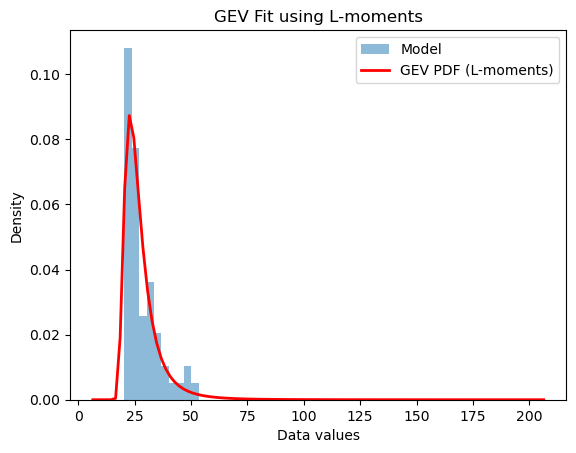

In [14]:
#Plotting
xx = np.linspace(l+0.00001, l+0.00001+200, num=100)
#xx = np.linspace(min(rain_over_threshold), max(rain_over_threshold), 100)
pdf_gev = ldist.gev.pdf(xx, **gev_params)
plt.hist(rain_POT, bins=10, density=True, alpha=0.5,  label="Model")
plt.plot(xx, pdf_gev, 'r-', lw=2, label="GEV PDF (L-moments)")
plt.xlabel("Data values")
plt.ylabel("Density")
plt.title("GEV Fit using L-moments")
plt.legend()
plt.show()

### F. Fit GPD (Generalized Pareto Distribution) to exceedances (MLE)

GPD Fit Parameters: Shape (ξ) = 0.0682, Scale (σ) = 6.8183, Location (μ) = 0


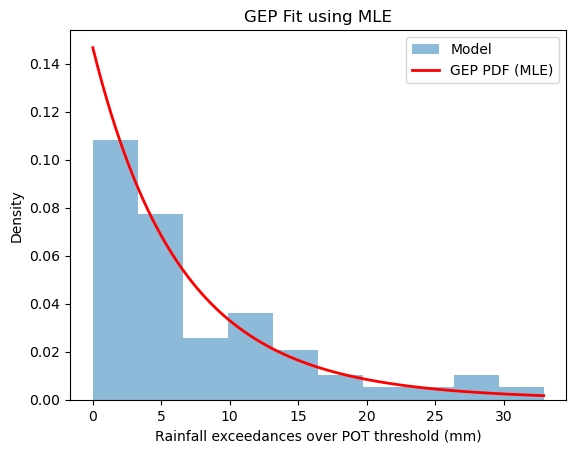

In [15]:
exceedances = rain_POT - POT_threshold
shape, loc, scale = stats.genpareto.fit(exceedances.values, floc=0)

print(f"GPD Fit Parameters: Shape (ξ) = {shape:.4f}, Scale (σ) = {scale:.4f}, Location (μ) = {loc}")

#Plotting
xx = np.linspace(0, max(exceedances), num=100)
#xx = np.linspace(min(rain_over_threshold), max(rain_over_threshold), 100)
pdf_gep = stats.genpareto.pdf(xx, shape, loc=loc, scale=scale)
plt.hist(exceedances, bins=10, density=True, alpha=0.5, label="Model")
plt.plot(xx, pdf_gep, 'r-', lw=2, label="GEP PDF (MLE)")
plt.xlabel("Rainfall exceedances over POT threshold (mm)")
plt.ylabel("Density")
plt.title("GEP Fit using MLE")
plt.legend()
plt.show()


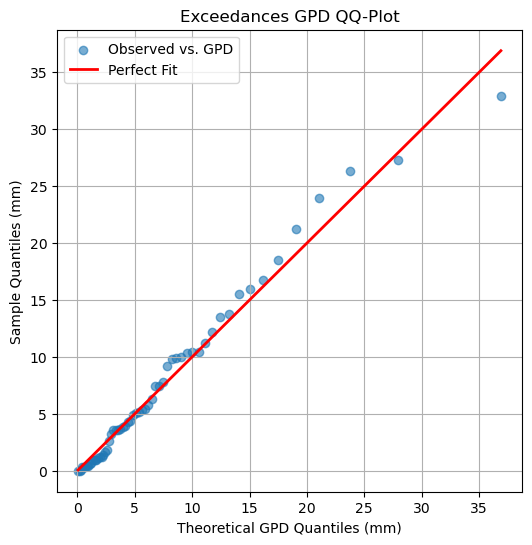

In [17]:
#QQ-Plots : Compare Data vd theoretical GPD (Generalized Pareto Distribution)

# Compute empirical and theoretical quantiles
quantiles = np.linspace(0.01, 0.99, len(exceedances)) #Here quantiles are probabilities values
empirical = np.sort(exceedances) #Values observed of exceedances over threshold
theoretical = stats.genpareto.ppf(quantiles, shape, loc=0, scale=scale) #Using Gen pareto distribution parameters, return value of exceedance expected for given probabilities

# Plot QQ-Plot
plt.figure(figsize=(6, 6))
plt.scatter(theoretical, empirical, label="Observed vs. GPD", alpha=0.6)
plt.plot(theoretical, theoretical, 'r-', label="Perfect Fit", linewidth=2)
plt.xlabel(f"Theoretical GPD Quantiles (mm)")
plt.ylabel(f"Sample Quantiles (mm)")
plt.title("Exceedances GPD QQ-Plot")
plt.legend()
plt.grid()
plt.show()